# Packages

In [1]:
# for reading in datasets and data manipulation
import pandas as pd
from datetime import datetime

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()

# for iterations
from tqdm import tqdm

# ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# Data Cleaning

This is a notebook for exploring and cleaning the provided data. After conducting necessary operations, a final dataset will be created that will be used to create the recommendation model.

In [2]:
# function to read in datasets
def read_data(filename):
    df = pd.read_csv(str(filename))
    return df

In [3]:
data = read_data('../data/events.csv') # reading the dataset
data.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [4]:
# checking column types
data.dtypes

timestamp          int64
visitorid          int64
event             object
itemid             int64
transactionid    float64
dtype: object

In [5]:
data.isnull().sum() # nulls caused by other events than transaction, this is not a problem since I will only use view events

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64

In [6]:
# checking dataset information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [7]:
# checking duplicate values
data[data.duplicated()]

,timestamp,visitorid,event,itemid,transactionid
22404,1433180781440,1045411,addtocart,379647,NaN
34465,1433274223925,366538,addtocart,252068,NaN
39738,1433265100661,198153,addtocart,48715,NaN
41774,1433270868154,1268755,view,60980,NaN
42469,1433277134682,555487,addtocart,397642,NaN
...,...,...,...,...,...
2748964,1438346018813,722488,view,97303,NaN
2750464,1438370523152,896869,addtocart,85004,NaN
2752725,1438405570135,708442,addtocart,392883,NaN
2753763,1438376127329,372829,addtocart,388276,NaN


In [8]:
data = data.drop_duplicates(keep='first') # dropping duplicate rows

In [9]:
# changing integer columns to string
data['visitorid'] = data['visitorid'].astype(str)
data['itemid'] = data['itemid'].astype(str)

In [10]:
# checking column types once again
data.dtypes

timestamp          int64
visitorid         object
event             object
itemid            object
transactionid    float64
dtype: object

In [11]:
# I am filtering my dataset because I am only going to use the view data
data = data[data['event'] == 'view'].copy()
data = data.drop(['event', 'transactionid'], axis=1)
data.head()

,timestamp,visitorid,itemid
0,1433221332117,257597,355908
1,1433224214164,992329,248676
2,1433221999827,111016,318965
3,1433221955914,483717,253185
4,1433221337106,951259,367447


# Data Exploration

In [12]:
# function for data grouping
def group_numerical_data(df_name, df_grouped_column, categorical_column):
    df = df_name.groupby(str(df_grouped_column)).agg({str(categorical_column): lambda x: len(x)}).reset_index()
    return df

In [13]:
# function to see the distribution of provided columns
def plot_distribution(df_column_name,bins=0):
    plt.figure(figsize=(16,6))
    sns.distplot(df_column_name, bins=bins, kde=False)
    plt.axvline(df_column_name.median(), c="r", label=f"Median : {int(df_column_name.median())}")
    plt.xlabel('# of products')
    plt.legend()
    plt.show()

In [14]:
# looking at the popular products
popular_products = group_numerical_data(data, 'itemid', 'visitorid')

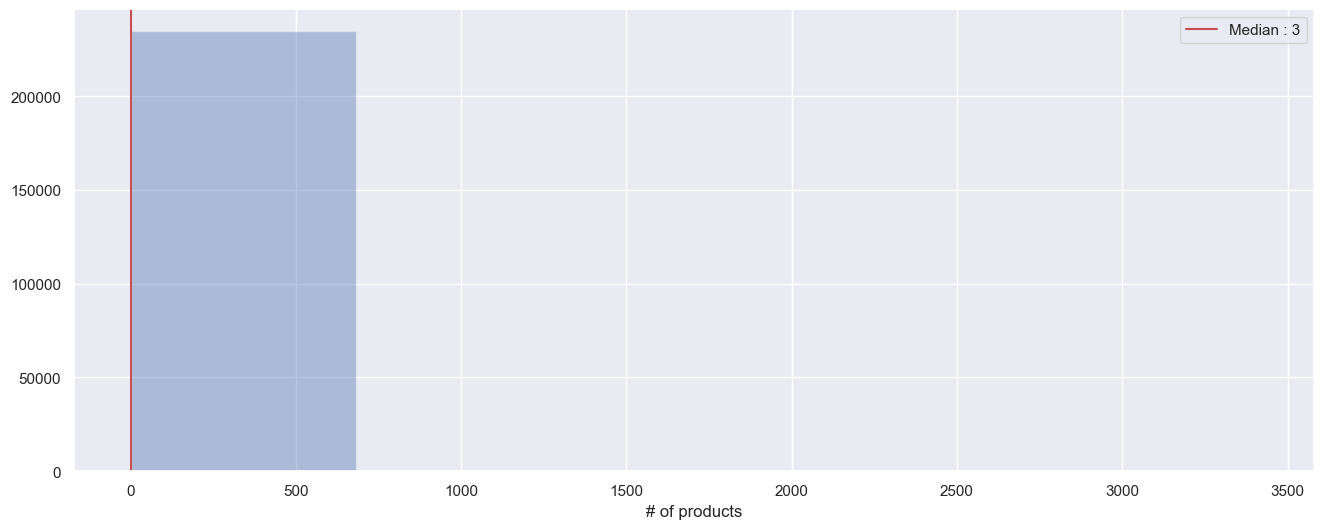

In [15]:
# plotting distribution
plot_distribution(popular_products['visitorid'],bins=5)

In [16]:
popular_products.sort_values(by='visitorid', ascending=True) # visitorid column is actullay the number of product views for particular product

,itemid,visitorid
234837,99999,1
109847,296628,1
202245,461839,1
202246,461840,1
56043,200655,1
...,...,...
66605,219512,1740
151293,370653,1854
209228,5411,2325
202159,461686,2538


In [17]:
print('# of products that are only viewed once:', popular_products[popular_products['visitorid'] == 1].shape[0])
print('# of unique products:', popular_products.shape[0])

# of products that are only viewed once: 73799
# of unique products: 234838


From above we can see 73799 products are viewed only once and the distribution is rather skewed. I am not going to delete those products that are only viewed once because it will make my dataset more biased towards popular products. 

In [18]:
# grouping by user to see how many products are viewed per user
products_viewed_per_user = group_numerical_data(data, 'visitorid', 'itemid')

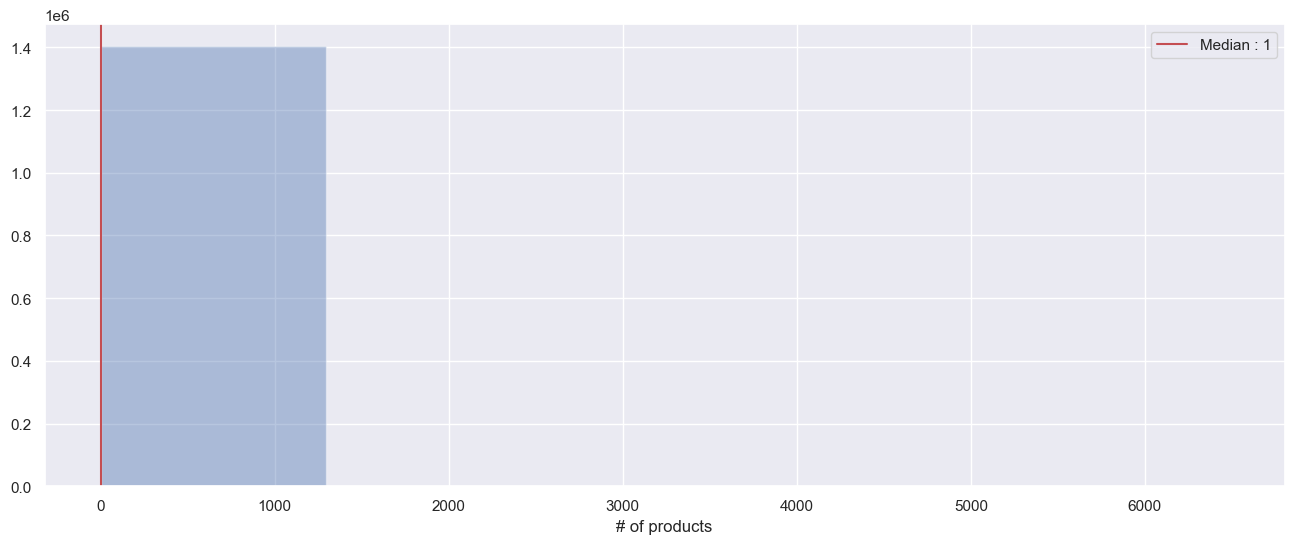

In [19]:
# plotting distribution
plot_distribution(products_viewed_per_user['itemid'],bins=5)

In [20]:
products_viewed_per_user.sort_values(by='itemid', ascending=True) # itemid column represents the number of products that particular user views

,visitorid,itemid
702089,366571,1
858738,507888,1
858739,507889,1
858740,50789,1
858741,507890,1
...,...,...
477084,163561,2194
465335,152963,2304
1288939,895999,2368
883881,530559,3623


From the plot distribution and litte dataset above, for most of the users, we can see that the amount of products viewed per user varies between one and somewhere over thousands. I am going to delete those user_ids that only viewed 1 product because I consider them as outliers and these kind of users make it hard to build strong recommendations due to user cold start problem.

In [21]:
# saving outlier user_ids to a list
outliers = products_viewed_per_user[products_viewed_per_user['itemid'] == 1].index.tolist()

In [22]:
# deleting outlier user ids from original dataset
data = data[~data['visitorid'].isin(outliers)]

In [23]:
# function to delete consecutive views made by users and only keeping one
def delete_consecutives_1(dataframe):
    final_df = pd.DataFrame() # creating an empty data frame for cleaned dataset
    user_id_list = dataframe['visitorid'].unique().tolist() # putting user_ids to list

    for user_id in tqdm(user_id_list[:400000]):
        filtered_data = dataframe[dataframe['visitorid'] == str(user_id)].sort_values(by='timestamp', ascending=False)
        filtered_data = filtered_data.loc[filtered_data['itemid'].shift() != filtered_data['itemid']]
        final_df = final_df.append(filtered_data, ignore_index=True)
    
    return final_df.to_csv('../data/final_data_1.csv', index=False)

In [24]:
delete_consecutives_1(data)

100%|██████████| 400000/400000 [31:00:46<00:00,  3.58it/s]   


In [25]:
# function to delete consecutive views made by users and only keeping one
def delete_consecutives_2(dataframe):
    final_df = pd.DataFrame() # creating an empty data frame for cleaned dataset
    user_id_list = dataframe['visitorid'].unique().tolist() # putting user_ids to list

    for user_id in tqdm(user_id_list[400000:800000]):
        filtered_data = dataframe[dataframe['visitorid'] == str(user_id)].sort_values(by='timestamp', ascending=False)
        filtered_data = filtered_data.loc[filtered_data['itemid'].shift() != filtered_data['itemid']]
        final_df = final_df.append(filtered_data, ignore_index=True)
    
    return final_df.to_csv('../data/final_data_2.csv', index=False)

In [26]:
delete_consecutives_2(data)

100%|██████████| 400000/400000 [29:05:55<00:00,  3.82it/s]   


In [27]:
# function to delete consecutive views made by users and only keeping one
def delete_consecutives_3(dataframe):
    final_df = pd.DataFrame() # creating an empty data frame for cleaned dataset
    user_id_list = dataframe['visitorid'].unique().tolist() # putting user_ids to list

    for user_id in tqdm(user_id_list[800000:]):
        filtered_data = dataframe[dataframe['visitorid'] == str(user_id)].sort_values(by='timestamp', ascending=False)
        filtered_data = filtered_data.loc[filtered_data['itemid'].shift() != filtered_data['itemid']]
        final_df = final_df.append(filtered_data, ignore_index=True)
    
    return final_df.to_csv('../data/final_data_3.csv', index=False)

In [28]:
delete_consecutives_3(data)

100%|██████████| 604179/604179 [45:30:26<00:00,  3.69it/s]   
